In [1]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stg_energy.fig3_amortize_energy.viz as viz
from pyloric import create_prior, get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)

# Figure 3

In [2]:
%load_ext autoreload
%autoreload 2

In [116]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_REG_A1 = "../svg/panel_reg_a1.svg"
PANEL_REG_A2 = "../svg/panel_reg_a2.svg"
PANEL_REG_B = "../svg/panel_reg_b.svg"
PANEL_REG_C = "../svg/panel_reg_c.svg"
PANEL_REG_D1 = "../svg/panel_reg_d1.svg"
PANEL_REG_D2 = "../svg/panel_reg_d2.svg"
PANEL_REG_D3 = "../svg/panel_reg_d3.svg"
PANEL_REG_D4 = "../svg/panel_reg_d4.svg"
PANEL_REG_E = "../svg/panel_reg_e.svg"
PANEL_REG_F = "../svg/panel_reg_f.svg"
PANEL_REG_G = "../svg/panel_reg_g.svg"
PANEL_REG_H = "../svg/panel_reg_h.svg"
PANEL_REG_G2 = "../svg/panel_reg_g2.svg"
PANEL_REG_H2 = "../svg/panel_reg_h2.svg"
PANEL_quality_of_approx_NN = "../svg/panel_quality_of_approx_NN.svg"
PANEL_NN_REG = "../../fig4_sensitivity/svg/panel_nn_reg.svg"

### Load experimental data

In [4]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray(
    [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [5]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
good_stats = data["sample_stats"]
good_params = data["sample_params"]
good_seeds = data["sample_seeds"]

In [6]:
sample_params = good_params
sample_stats = good_stats
print("There are", len(good_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [7]:
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [8]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

### Quantify the variances

In [9]:
prior_range = (prior_11.support.upper_bound - prior_11.support.lower_bound).numpy()

In [10]:
inds = np.argsort(summed_energies)
sorted_energies = np.sort(summed_energies)
sorted_params = sample_params[inds]
sorted_ss = sample_stats[inds]

In [11]:
all_means = []
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:

    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]
    energy_thr = sorted_energies[int(num_vals * quantile)]

    mean_of_these_params = np.mean(params_to_plot, axis=0)
    all_means.append(mean_of_these_params)
all_means = np.asarray(all_means)

In [12]:
energy_thr

1721441.8802888643

### Plot histogram

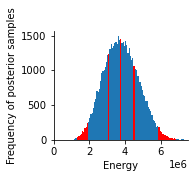

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(2.4, 2))

N, bins, patches = ax.hist(summed_energies, bins=100)

for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:
    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]
    energy_thr_low = sorted_energies[int(num_vals * quantile - num_samples / 2)]
    energy_thr_high = sorted_energies[int(num_vals * quantile + num_samples / 2)]

    for i, b in enumerate(bins):
        if b > energy_thr_low and b < energy_thr_high:
            patches[i].set_facecolor("r")

ax.set_xlim(0, 7500000)
ax.set_xlabel("Energy")
ax.set_ylabel("Frequency of posterior samples")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.savefig('../results/energy/figs_new/histogram.png', dpi=300, bbox_inches='tight')

In [14]:
shift_in_mean = all_means[0] - all_means[-1]
shift_in_mean_normalized = shift_in_mean / prior_range

In [15]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
strongest_variation_inds = np.sort(sort_inds[-8:])  # these are used for plots

In [16]:
labels_ = get_labels_8pt()
labels_[9] += ""

In [17]:
from decimal import Decimal

all_labels = []
lims = lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5:  # synapses
        if dim_i == 24:
            all_labels.append(
                [r"$\mathdefault{0.01}$     ", r"$\mathdefault{10000}\;\;\;\;$   "]
            )
        else:
            all_labels.append(
                [r"$\mathdefault{0.01}$ ", r"$\mathdefault{1000}\;\;\;\;$ "]
            )
    else:  # membrane conductances
        num_after_digits = -int(
            np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
        )
        if num_after_digits > 2:
            num_after_digits = 2
        labels = [
            round(
                Decimal(
                    (lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i])
                    / 0.628e-3
                ),
                num_after_digits,
            )
            for num_tmp in range(2)
        ]
        new_labels = []
        counter = 0
        for l in labels:
            if counter == 0:
                new_labels.append(r"$\mathdefault{" + str(l) + "}$  ")
            else:
                new_labels.append(r"$\mathdefault{" + str(l) + "}\;\;\;$  ")
            counter += 1
        all_labels.append(new_labels)

# Panel 0: Fit regression net

In [18]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [19]:
print(energies.shape)

torch.Size([55043, 3])


In [20]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [21]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [22]:
nn = classifier(dim=31)

In [23]:
# converged_nn = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_energy_ABPD_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200,
# )
# np.savez('../../results/regression_nets/200923_predict_total_energy_sum_over_all_neurons.npz', converged_nn=converged_nn)

In [24]:
data = np.load(
    "../../results/regression_nets/200923_predict_total_energy_sum_over_all_neurons.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [25]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

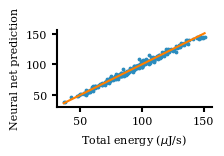

In [184]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy()/40000, y=unnorm_y.numpy()/40000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/40000, np.max(unnorm_x.numpy())/40000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_quality_of_approx_NN, facecolor='None', transparent=False)

In [27]:
cum_grad = get_gradient(converged_nn, test_params_norm)

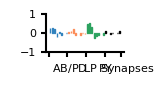

In [28]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1, 1], figsize=(1.0,0.5))
    plt.show()

In [29]:
e_vals, e_vecs = active_subspace(converged_nn, test_params_norm)

### Plot correlation between parameter and energy

In [30]:
import seaborn as sns
import pandas as pd

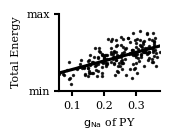

In [159]:
PY_Na = good_params[:, 16]
num_scatter = 200

df = pd.DataFrame(data=[PY_Na[:num_scatter], summed_energies[:num_scatter]], index=["PY_Na", "total_energy"])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1.0))
    sns.regplot(x=PY_Na[:num_scatter], y=summed_energies[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{Na}}$ of PY')
    ax.set_ylabel('Total Energy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_label_coords(0.5, -0.35)
    ax.set_ylim([np.min(summed_energies), np.max(summed_energies)])
    ax.set_yticks([np.min(summed_energies), np.max(summed_energies)])
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_REG_A1, facecolor='None', transparent=False)

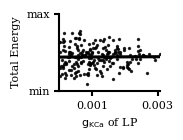

In [160]:
ABPD_Na = good_params[:, 20]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1))
    sns.regplot(x=ABPD_Na[:num_scatter], y=summed_energies[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{KCa}}$ of LP')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([np.min(summed_energies), np.max(summed_energies)])
    ax.set_ylabel('Total Energy')
    ax.set_yticks([np.min(summed_energies), np.max(summed_energies)])
    ax.set_yticklabels(["min", "max"])
#     ax.set_yticks([])
    ax.set_xticks([0.001, 0.003])
    plt.savefig(PANEL_REG_A2, facecolor='None', transparent=False)

### Sketch of active subspace

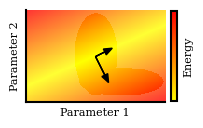

In [35]:
from matplotlib.colors import Normalize
import matplotlib.cm

figureratio = 1.5
figuresize = 1.3

vec1 = np.linspace(-3,3,int(figureratio * 100))
vec2 = np.linspace(-3,3,100)

X,Y = np.meshgrid(vec1, vec2)
dist = np.abs(X + 1.5*Y)

m_e = [0.0, -.1]
s_e = [6., 0.7]
m_e_2 = [1.1, 1.7]
s_e_2 = [1.5, 6.]
dists_e_1 = s_e[0]*(X-m_e[0])**2 + s_e[1]*(Y-m_e[1])**2
dists_e_2 = s_e_2[0]*(X-m_e_2[0])**2 + s_e_2[1]*(Y-m_e_2[1])**2
dists_e = np.minimum(dists_e_1, dists_e_2)
allowed_dist = 5.0
thr_dists_e = dists_e < allowed_dist
inds = np.where(np.abs(dists_e - allowed_dist) < 0.5)
inds = np.asarray(inds).T
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(figureratio*figuresize,figuresize))\

    # We'll also create a grey background into which the pixels will fade
    greys = np.ones((*dist.shape, 3))

    image_to_plot = -dist
    max_of_image = np.max(image_to_plot)
    min_of_image = np.min(image_to_plot)
    dist_of_min_max = max_of_image + min_of_image
    image_to_plot = image_to_plot - dist_of_min_max / 2

    # First we'll plot these blobs using only ``imshow``.
    vmax = np.abs(image_to_plot).max()
    vmin = -vmax
    cmap = matplotlib.cm.get_cmap('autumn')

#     for i1 in inds:
#         for i2 in inds:
#             x1, y1 = i1
#             x2, y2 = i2
#             ddd1 = np.abs(x1 - x2)
#             ddd2 = np.abs(y1 - y2)
#             if ddd1 < 1.5 and ddd2 < 1.5:
#                 plt.plot([y1, y2], [x1, x2], '#525252', linewidth=0.3)

    # Create an alpha channel of linearly increasing values moving to the right.
    alphas = 1.0 - 0.2*(1-thr_dists_e)
#     alphas = np.ones_like(image_to_plot)

    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors = Normalize(vmin, vmax, clip=True)(image_to_plot)
    colors = cmap(colors)

    # Now set the alpha channel to the one we created above
    colors[..., -1] = alphas

    i = np.ones((100,150))
    ii = plt.imshow(i, cmap=matplotlib.cm.get_cmap('autumn_r'))
    ax.imshow(greys, cmap='Greys', clim=[0,1])
    im = ax.imshow(colors, clim=[-0.1, 0.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Parameter 1")
    ax.set_ylabel("Parameter 2")

    cbar = plt.colorbar(ii, aspect=15,fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label('Energy', labelpad=5)
    ax.arrow(75, 50, 10, -5, head_width=7, head_length=9, facecolor='k')
    ax.arrow(75, 50, 10, 20, head_width=7, head_length=9, facecolor='k')
    plt.savefig(PANEL_REG_B, facecolor='None', transparent=False)

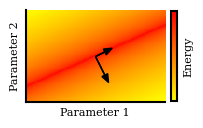

In [36]:
from matplotlib.colors import Normalize
import matplotlib.cm

figureratio = 1.5
figuresize = 1.3

vec1 = np.linspace(-3,3,int(figureratio * 100))
vec2 = np.linspace(-3,3,100)

X,Y = np.meshgrid(vec1, vec2)
dist = np.abs(X + 1.5*Y)

m_e = [0.0, -.1]
s_e = [6., 0.7]
m_e_2 = [1.1, 1.7]
s_e_2 = [1.5, 6.]
dists_e_1 = s_e[0]*(X-m_e[0])**2 + s_e[1]*(Y-m_e[1])**2
dists_e_2 = s_e_2[0]*(X-m_e_2[0])**2 + s_e_2[1]*(Y-m_e_2[1])**2
dists_e = np.minimum(dists_e_1, dists_e_2)
allowed_dist = 5.0
thr_dists_e = dists_e < allowed_dist
inds = np.where(np.abs(dists_e - allowed_dist) < 0.5)
inds = np.asarray(inds).T
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(figureratio*figuresize,figuresize))\

    image_to_plot = -np.sqrt(dist)
    
    im = ax.imshow(image_to_plot, cmap='autumn_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Parameter 1")
    ax.set_ylabel("Parameter 2")

    cbar = plt.colorbar(ii, aspect=15,fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label('Energy', labelpad=5)
    ax.arrow(75, 50, 10, -5, head_width=7, head_length=9, facecolor='k')
    ax.arrow(75, 50, 10, 20, head_width=7, head_length=9, facecolor='k')
    plt.savefig(PANEL_REG_B, facecolor='None', transparent=False)

### Plot all 31D eigenvalues
It seems that energy lies largely in a 1D subspace. As we will show below, within theis subspace, it is possible to optimize both the energy/spike and the number of spikes.

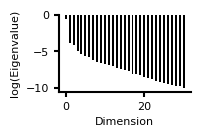

In [139]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_eigenvalues(torch.log(torch.flip(e_vals, dims=(0,))), figsize=(1.7, 1.0), color='k')
    plt.savefig(PANEL_REG_C, facecolor='None', transparent=False)
    plt.show()

### Plot first eigenvector

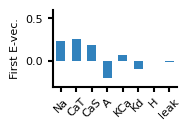

In [140]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[0:8, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='First E-vec.', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1, facecolor='None', transparent=False)
    plt.show()

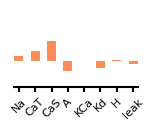

In [141]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[8:16, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2, facecolor='None', transparent=False)
    plt.show()

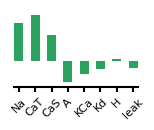

In [142]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[16:24, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3, facecolor='None', transparent=False)
    plt.show()

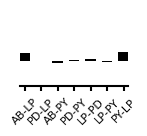

In [143]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(e_vecs[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel='', color="k")
    plt.savefig(PANEL_REG_D4, facecolor='None', transparent=False)
    plt.show()

In [144]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     viz.py_sensitivity_bars(e_vecs[16:24, -1:].T, ylim=[-0.3, 0.6], figsize=(2.8, 1.0), ylabel='PY neuron', color="#2ca25f")
#     plt.savefig(PANEL_REG_E, facecolor='None', transparent=False)
#     plt.show()

### Project into 1D plane

In [145]:
num_scatter = 1000

projection_mat = e_vecs[:, -1:]
train_params_norm_tt = torch.as_tensor(train_params_norm)[:num_scatter]
all_train_params_norm_tt = torch.as_tensor(train_params_norm)
projected = torch.mm(train_params_norm_tt, projection_mat)[:num_scatter]
all_projected = torch.mm(all_train_params_norm_tt, projection_mat)

In [146]:
minimal_dim0_set = projected[torch.argmin(projected[:, 0])]
maximal_dim0_set = projected[torch.argmax(projected[:, 0])]

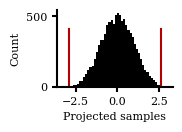

In [147]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    _ = ax.hist(all_projected[:10000].T, bins=50, facecolor='k')
    ax.axvline(minimal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.axvline(maximal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Projected samples")
    ax.set_ylabel("Count")
    plt.savefig(PANEL_REG_F, facecolor='None', transparent=False)

### Simulate the most extreme cases and show the PY neuron

In [148]:
min_of_energy_PY = torch.min(torch.sum(energies, dim=1)) 
max_of_energy_PY = torch.max(torch.sum(energies, dim=1)) 
print(max_of_energy_PY)

tensor(7542451.3953, dtype=torch.float64)


In [149]:
min_num_spikes_PY = torch.min(torch.sum(sample_stats[:, -6:-3], dim=1)) 
max_num_spikes_PY = torch.max(torch.sum(sample_stats[:, -6:-3], dim=1)) 
print(min_num_spikes_PY)
print(max_num_spikes_PY)

tensor(210., dtype=torch.float64)
tensor(625., dtype=torch.float64)


In [150]:
unnorm_set_dim0_min = (
    train_params_norm_tt[torch.argmin(projected[:, 0])] * std_params + mean_params
)
unnorm_set_dim0_max = (
    train_params_norm_tt[torch.argmax(projected[:, 0])] * std_params + mean_params
)
simulation_output_dim0_min = simulate_energyscape(unnorm_set_dim0_min, seed=0)
simulation_output_dim0_max = simulate_energyscape(unnorm_set_dim0_max, seed=0)

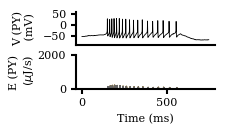

In [151]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_min,
        get_time(),
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=100000,
    )
    plt.savefig(PANEL_REG_G, facecolor='None', transparent=False)
# 18 spikes

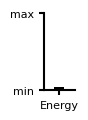

In [152]:
summstats = stats(simulation_output_dim0_min)
energies_PY_sim = np.sum(summstats[28:31])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.4,1.0))
    height_energy = (energies_PY_sim - min_of_energy_PY) / (max_of_energy_PY - min_of_energy_PY)
    ax.bar(np.arange(0,1), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0,1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Energy'])
    ax.set_yticklabels(['min', 'max'])
    plt.savefig(PANEL_REG_G2, facecolor='None', transparent=False)
    plt.show()

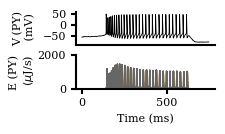

In [153]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_max,
        get_time(),
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=37000,
    )
    plt.savefig(PANEL_REG_H, facecolor='None', transparent=False)
# 29 spikes

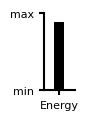

In [154]:
summstats = stats(simulation_output_dim0_max)
energies_PY_sim = np.sum(summstats[28:31])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.4,1.0))
    height_energy = (energies_PY_sim - min_of_energy_PY) / (max_of_energy_PY - min_of_energy_PY)
    ax.bar(np.arange(0,2), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0,1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Energy'])
    ax.set_yticklabels(['min', 'max'])
    plt.savefig(PANEL_REG_H2, facecolor='None', transparent=False)
    plt.show()

In [155]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [182]:
# from svgutils.compose import *

# # > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# # > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
# svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
# factor_svg=5.5

# # Panel letters in Helvetica Neue, 12pt, Medium
# kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
# kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
# kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
# kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
# kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

# f = Figure("20.3cm", "10.0cm",
           
#     Panel(
#           SVG(PANEL_REG_A1).scale(svg_scale).move(0, 0*factor_svg),
#           Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(2*factor_svg, 0*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_A2).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(29*factor_svg, 0.6*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_B).scale(svg_scale).move(0, 0*factor_svg),
#           Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#           Text("inactive", 15.0*factor_svg, 7.0*factor_svg, **kwargs_text8pt),
#           Text("active", 11.0*factor_svg, 13.5*factor_svg, **kwargs_text8pt),
#     ).move(68*factor_svg, 0*factor_svg),

#     Panel(
#           SVG(PANEL_REG_C).scale(svg_scale).move(0, 0*factor_svg),
#           Text("c", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(105*factor_svg, 0*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_D1).scale(svg_scale).move(0, 0*factor_svg),
#           Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#         Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
#     ).move(2*factor_svg, 23*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_D2).scale(svg_scale).move(0, 0*factor_svg),
#         Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
#     ).move(32*factor_svg, 23*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_D3).scale(svg_scale).move(0, 0*factor_svg),
#         Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
#     ).move(56*factor_svg, 23*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_D4).scale(svg_scale).move(0, 0*factor_svg),
#         Text("Synapses", 7.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
#     ).move(79*factor_svg, 23*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_F).scale(svg_scale).move(0, 0*factor_svg),
#           Text("e", -1.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#           Text("f", 11.1*factor_svg, 3.5*factor_svg, **kwargs_text8pt_red),
#           Text("g", 26.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt_red),
#     ).move(108*factor_svg, 23*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_G).scale(svg_scale).move(0, 0*factor_svg),
#           Text("f", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(2*factor_svg, 47.4*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_G2).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(51.5*factor_svg, 46.7*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_H).scale(svg_scale).move(0, 0*factor_svg),
#           Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(73*factor_svg, 47*factor_svg),
    
#     Panel(
#           SVG(PANEL_REG_H2).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(122.5*factor_svg, 46.7*factor_svg),
# )

# !mkdir -p fig
# f.save("../fig/fig3_reg.svg")
# svg('../fig/fig3_reg.svg')

In [183]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "10.0cm",
           
    Panel(
          SVG(PANEL_REG_A1).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_REG_A2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(29*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_NN_REG).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -4.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(67*factor_svg, 7*factor_svg),
    
    Panel(
          SVG(PANEL_REG_B).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
          Text("inactive", 15.0*factor_svg, 7.0*factor_svg, **kwargs_text8pt),
          Text("active", 11.0*factor_svg, 13.5*factor_svg, **kwargs_text8pt),
    ).move(107*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_REG_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg,23*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D1).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
        Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(39*factor_svg, 23*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D2).scale(svg_scale).move(0, 0*factor_svg),
        Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(69*factor_svg, 23*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D3).scale(svg_scale).move(0, 0*factor_svg),
        Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(93*factor_svg, 23*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D4).scale(svg_scale).move(0, 0*factor_svg),
        Text("Synapses", 7.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(116*factor_svg, 23*factor_svg),
    
    Panel(
          SVG(PANEL_REG_F).scale(svg_scale).move(0, 0*factor_svg),
          Text("f", -1.7*factor_svg, 1.9*factor_svg, **kwargs_text),
          Text("g", 11.1*factor_svg, 3.5*factor_svg, **kwargs_text8pt_red),
          Text("h", 26.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt_red),
    ).move(1.7*factor_svg, 48*factor_svg),
    
    Panel(
          SVG(PANEL_REG_G).scale(svg_scale).move(0, 0*factor_svg),
          Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(36*factor_svg, 47.4*factor_svg),
    
    Panel(
          SVG(PANEL_REG_G2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(70.5*factor_svg, 46.7*factor_svg),
    
    Panel(
          SVG(PANEL_REG_H).scale(svg_scale).move(0, 0*factor_svg),
          Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(90*factor_svg, 47*factor_svg),
    
    Panel(
          SVG(PANEL_REG_H2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(124.5*factor_svg, 46.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_reg.svg")
svg('../fig/fig3_reg.svg')

# Panel A: posterior for parameters that change a lot

In [272]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]
    energy_thr_low = sorted_energies[int(num_vals * quantile - num_samples / 2)]
    energy_thr_high = sorted_energies[int(num_vals * quantile + num_samples / 2)]
    print("energy_thr", energy_thr_low, energy_thr_high)

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axes = viz.oneDmarginal(
        samples=all_sample_params,
        subset=strongest_variation_inds.tolist(),
        limits=lims,
        ticks=lims,
        tick_labels=all_labels,
        fig_size=(10, 1.3),
        labels=labels_,
        samples_colors=[col["SNPE"], "r"],
        diag=["kde", "kde"],
        hist_offdiag={"bins": 50},
    )
    # plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

KeyError: 'sample_stats is not a file in the archive'

# Panel B: posterior for parameters that barely change

In [ ]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
weakest_variation_inds = np.sort(sort_inds[:8])  # these are used for plots

In [ ]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axes = viz.oneDmarginal(
        samples=all_sample_params,
        subset=weakest_variation_inds.tolist(),
        limits=lims,
        ticks=lims,
        tick_labels=all_labels,
        fig_size=(10, 1.3),
        labels=labels_,
        samples_colors=[col["SNPE"], "r"],
        diag=["kde", "kde"],
        hist_offdiag={"bins": 50},
    )
    # plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

# Panel C: summarize

In [ ]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.sensitivity_hist(shift_in_mean_normalized, figsize=(10, 1))
    # plt.savefig(PANEL_C, facecolor='None', transparent=True)

# Assemble figure

In [ ]:
import time

import IPython.display as IPd


def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [26]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.0cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 56*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3.svg")
svg('../fig/fig3.svg')